In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize as op
import warnings
import time
import emcee
from matplotlib import rcParams
rcParams["font.size"] = 10
rcParams["axes.linewidth"] = 3
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.width'] = 1.5
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 4
rcParams['ytick.minor.width'] = 1.5

warnings.filterwarnings("ignore", category=np.RankWarning)

#--------------------------------single lens ---------------------------------------#

def single_magnification(t0,tE,u0,t):
    u = np.sqrt(u0**2 + ((t-t0)/tE)**2)
    A = (u**2 + 2)/(u*np.sqrt(u**2 +4))
    return A

def get_flux_single(t0,tE,u0,data_time,data_flux,data_ferr):
    A = single_magnification(t0,tE,u0,data_time)
    fs, fb = np.polyfit(A, data_flux, 1,w=1/data_ferr)
    return fs, fb
    
def get_chi2_single(t0,tE,u0,data_time,data_flux,data_ferr):
    A = single_magnification(t0,tE,u0,data_time)
    fs, fb = get_flux_single(t0,tE,u0,data_time,data_flux,data_ferr)
    model_flux = A*fs + fb
    chi2 = np.sum(((data_flux-model_flux)/data_ferr)**2)
    return chi2
    
def chi2_fun_single(theta,data_time,data_flux,data_ferr):
    if theta[1] <= 0 or theta[2] <= 0:
        return -np.inf
    else:
        return get_chi2_single(theta[0],theta[1],theta[2],data_time,data_flux,data_ferr)

def single_fit(t0_init,tE_init,u0_init,data_time,data_flux,data_ferr):
    initial_guess = [t0_init, tE_init,u0_init]
    
    result = op.minimize(chi2_fun_single, x0=initial_guess,args=(data_time,data_flux,data_ferr),method='Nelder-Mead')
    
    (fit_t0, fit_tE,fit_u0) = result.x
    return fit_t0, fit_tE, fit_u0

def get_lc_PSPL(t0,tE,u0,fs,fb,t_range):
    t_ref = np.linspace(t_range[0],t_range[1],10000)
    f_model = fs* single_magnification(t0,tE,u0,t_ref) + fb
    lc_model = np.empty(len(t_ref), dtype=[("time", float), ("flux", float)])
    lc_model["time"] = t_ref
    lc_model["flux"] = f_model
    return lc_model

#------------------------------------------------------------------------------------#

#----------------------for mcmc-----------------------------------------#

def ln_posterior(theta, data_time, data_flux, data_ferr):
    if theta[1] <= 0 or theta[2] <= 0:
        return -np.inf
    else:
        chi2 = get_chi2_single(theta[0],theta[1],theta[2],data_time,data_flux,data_ferr)
        return  -0.5 *chi2

def single_fit_mcmc(t0_init, tE_init, u0_init, data_time, data_flux, data_ferr):
    ndim = 3 
    nwalkers = 20  
    pos = [np.array([t0_init, tE_init, u0_init]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(data_time, data_flux, data_ferr))
    sampler.run_mcmc(pos, 1000)

    samples = sampler.get_chain(discard=100, thin=10, flat=True)
    fit_t0, fit_tE, fit_u0 = np.percentile(samples, 50, axis=0)

    return fit_t0, fit_tE, fit_u0

#------------------------------------------------------------------------------------#

#--------------------------------discrete single lens---------------------------------------#

def calc_A_j_0(t0,teff,t):
    Q = 1+((t-t0)/teff)**2
    A = 1/np.sqrt(Q)  
    return A

def calc_A_j_1(t0,teff,t):
    Q = 1+((t-t0)/teff)**2
    A = (Q+2)/np.sqrt(Q*(Q+4))
    return A

def calc_A_comb(t0,teff,t):
    A_j_0 = calc_A_j_0(t0,teff,t)
    A_j_1 = calc_A_j_1(t0,teff,t)
    A = A_j_0 + A_j_1
    return A
    
def get_chi2_comb(t0,teff,data_time,data_flux,data_ferr):
    A_comb = calc_A_comb(t0,teff,data_time)
    fs, fb = get_flux_comb(t0,teff,data_time,data_flux,data_ferr)
    model_flux = A_comb*fs + fb
    chi2 = np.sum(((data_flux-model_flux)/data_ferr)**2)
    return chi2

def get_flux_comb(t0,teff,data_time,data_flux,data_ferr):
    A_comb = calc_A_comb(t0,teff,data_time)
    f1, f0 = np.polyfit(A_comb, data_flux, 1,w=1/data_ferr)
    return f1,f0

def chi2_fun_comb(theta,data_time,data_flux,data_ferr):
    return get_chi2_comb(theta[0],theta[1],data_time,data_flux,data_ferr)

def single_fit_2D(ferr,t0_init,teff_init,data_time,data_flux,data_ferr):
    initial_guess = [t0_init, teff_init]
    result = op.minimize(chi2_fun_comb, x0=initial_guess,args=(data_time,data_flux,data_ferr),method='Nelder-Mead')
    
    (fit_t0, fit_teff) = result.x
    return fit_t0, fit_teff

def get_chi2_flat(data_time,data_flux,data_ferr):
    bunsi = np.sum(data_flux/(data_ferr**2))
    bunbo= np.sum(1/(data_ferr**2))
    model_flux = bunsi/bunbo
    return np.sum(((data_flux-model_flux)/data_ferr)**2)

def get_chi2_0fit(data_time,data_flux,data_ferr):
    model_flux = np.zeros(data_time.shape[0])
    return np.sum(((data_flux-model_flux)/data_ferr)**2)

def get_lc_comb(t0,teff,f1,f0):
    t_range = [t0-3*teff ,t0+3*teff]
    t_ref = np.linspace(t_range[0],t_range[1],10000)
    f_model = f1* calc_A_comb(t0,teff,t_ref) + f0
    lc_model = np.empty(len(t_ref), dtype=[("time", float), ("flux", float)])
    lc_model["time"] = t_ref
    lc_model["flux"] = f_model
    return lc_model

#------------------------------------------------------------------------------------#

class AnomalyFinder():
    
    def set_data(self,path,subtract_2450000=False):
        self.data = np.genfromtxt(path,usecols=[0,1,2],names=["time","flux","ferr"])
        if subtract_2450000:
            self.data["time"]-=2450000
            
        del_ind = np.where((self.data["time"] < 1000) | (self.data["ferr"] <= 0)) #たまに意味のわからない時刻が入っているため
        self.data = np.delete(self.data, del_ind)
        
    def cut_data(self,t_range):
        cond1, cond2 = t_range[0] <self.data["time"], self.data["time"] < t_range[1]
        ind=np.where(cond1& cond2)[0]
        self.data = self.data[ind]
        
    def plot_data(self,t_range=False,**kwargs):
        if not t_range:
            t_range = [np.min(self.data["time"]),np.max(self.data["time"])]
        cond1, cond2 = t_range[0] <self.data["time"], self.data["time"] < t_range[1]
        ind=np.where(cond1&cond2)[0]
        plt.errorbar(self.data["time"][ind],self.data["flux"][ind],yerr=self.data["ferr"][ind],fmt="o",**kwargs)
        plt.xlabel("Time")
        plt.ylabel("Flux")
        plt.minorticks_on()
        
#     def PSPL_fit(self, t0_init,tE_init,u0_init,mcmc=False,**conds):
        
#         if mcmc:
#             (self.t0_PSPL,self.tE_PSPL,self.u0_PSPL) = single_fit_mcmc(t0_init,tE_init,u0_init,self.data["time"],self.data["flux"],self.data["ferr"])
#         else:
#             (self.t0_PSPL,self.tE_PSPL,self.u0_PSPL) = single_fit(t0_init,tE_init,u0_init,self.data["time"],self.data["flux"],self.data["ferr"])
#         self.fs_PSPL, self.fb_PSPL = get_flux_single(self.t0_PSPL,self.tE_PSPL,self.u0_PSPL,self.data["time"],self.data["flux"],self.data["ferr"])
#         self.teff_PSPL = self.tE_PSPL*self.u0_PSPL
        
#         self.f_PSPL = self.fs_PSPL*single_magnification(self.t0_PSPL,self.tE_PSPL,self.u0_PSPL,self.data["time"]) + self.fb_PSPL
#         self.f_residual = self.data["flux"]-self.f_PSPL

    def PSPL_fit(self, t0_init, tE_init, u0_init, mcmc=False, index = False):
        if index:
            selected_data = self.data[index]
        else:
            selected_data = self.data

        if mcmc:
            (self.t0_PSPL, self.tE_PSPL, self.u0_PSPL) = single_fit_mcmc(t0_init, tE_init, u0_init, selected_data["time"], selected_data["flux"], selected_data["ferr"])
        else:
            (self.t0_PSPL, self.tE_PSPL, self.u0_PSPL) = single_fit(t0_init, tE_init, u0_init, selected_data["time"], selected_data["flux"], selected_data["ferr"])

        self.fs_PSPL, self.fb_PSPL = get_flux_single(self.t0_PSPL, self.tE_PSPL, self.u0_PSPL, selected_data["time"], selected_data["flux"], selected_data["ferr"])
        self.teff_PSPL = self.tE_PSPL * self.u0_PSPL
        self.f_PSPL = self.fs_PSPL*single_magnification(self.t0_PSPL,self.tE_PSPL,self.u0_PSPL,self.data["time"]) + self.fb_PSPL
        self.f_residual = self.data["flux"]-self.f_PSPL
        
    def normalize_error(self,toeff=100):
        base_ind = np.where((self.data["time"] < self.t0_PSPL-self.teff_PSPL*toeff) | (self.data["time"] > self.t0_PSPL+self.teff_PSPL*toeff))[0]
        base_data = self.data[base_ind]
        base_A = single_magnification(self.t0_PSPL,self.tE_PSPL,self.u0_PSPL,base_data["time"])
        base_model_flux = base_A*self.fs_PSPL + self.fb_PSPL
        nout_ind = np.where(((base_data["flux"]-base_model_flux)/base_data["ferr"]) < 5)[0]
        base_chi2 = np.sum(((base_data["flux"][nout_ind]-base_model_flux[nout_ind])/base_data["ferr"][nout_ind])**2)
        coeff = np.sqrt(base_chi2/(base_data[nout_ind].shape[0]-5))
        self.data["ferr"] *= coeff
        
    def plot_residual_from_PSPL(self,t_range=False,ax0_ylims=False, **kwargs):
        if not t_range:
            t_range = [self.t0_PSPL-10*self.teff_PSPL, self.t0_PSPL+10*self.teff_PSPL]
        cond1, cond2 = t_range[0] <self.data["time"], self.data["time"] < t_range[1]
        ind=np.where(cond1&cond2)[0]
        self.lc_PSPL = get_lc_PSPL(self.t0_PSPL,self.tE_PSPL,self.u0_PSPL,self.fs_PSPL,self.fb_PSPL,t_range)
        fig, ax = plt.subplots(2, 1, figsize=(7.5, 6))
        gs = gridspec.GridSpec(2, 1, height_ratios=[8, 3])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[1])

        ax0.plot(self.lc_PSPL["time"],self.lc_PSPL["flux"],c="orange")
        ax0.errorbar(self.data["time"][ind],self.data["flux"][ind],yerr=self.data["ferr"][ind],fmt="o",**kwargs)
        ax0.set_ylabel("Flux")
        ax0.minorticks_on()
        ax0.set_xlim(t_range[0],t_range[1])
        if ax0_ylims:
            ax0.set_ylim(ax0_ylims[0], ax0_ylims[1])

        ax1.errorbar(self.data["time"][ind],self.f_residual[ind],yerr=self.data["ferr"][ind],fmt="o",**kwargs)
        ax1.plot([np.min(self.data["time"]), np.max(self.data["time"])], [0, 0], color='orange', linestyle='-')
        ax1.set_ylabel("Residual")
        ax1.set_xlabel("Time")
        ax1.minorticks_on()
        ax1.set_xlim(t_range[0],t_range[1])
        
    def run_grid_search(self,t_range=False,teff_init=0.01,common_ratio=4/3,dt0_coeff=1/6,teff_coeff=3,teff_grid=25):
        
        self.teff_coeff=teff_coeff #show anomaly signalで使うから
        
        teff_k = teff_init * np.power(common_ratio, np.arange(teff_grid))
        chi2_list, t0_ref_list, teff_ref_list, chi2_flat_list, chi2_0fit_list, d_chi2_flat_list, chi2_0fit_list, d_chi2_0fit_list =[],[],[],[],[],[],[],[]
        
        t_before = time.time()
        for teff_ref in teff_k:
            dt0 = dt0_coeff * teff_ref
            
            if t_range:
                t0_start, t0_end = t_range[0],t_range[1]
            else:
                t0_start, t0_end = np.min(self.data["time"]), np.max(self.data["time"])

            t0_j = np.arange(t0_start, t0_end+dt0,dt0)

            for t0_ref in t0_j:
                cond1, cond2 = t0_ref-teff_coeff*teff_ref <self.data["time"], self.data["time"] < t0_ref+teff_coeff*teff_ref #調節パラメータ
                ind=np.where(cond1&cond2)[0]
                if ind.shape[0] == 0:
                    chi2 = 0
                    chi2_flat = 0
                    chi2_0fit = 0
                else:
                    chi2 = get_chi2_comb(t0_ref,teff_ref,self.data["time"][ind],self.f_residual[ind],self.data["ferr"][ind])
                    chi2_flat = get_chi2_flat(self.data["time"][ind],self.f_residual[ind],self.data["ferr"][ind])
                    chi2_0fit = get_chi2_0fit(self.data["time"][ind],self.f_residual[ind],self.data["ferr"][ind])
                dchi2_flat = chi2_flat-chi2
                dchi2_0= chi2_0fit-chi2
                chi2_list.append(chi2)
                t0_ref_list.append(t0_ref)
                teff_ref_list.append(teff_ref)
                chi2_flat_list.append(chi2_flat)
                chi2_0fit_list.append(chi2_0fit)
                d_chi2_flat_list.append(dchi2_flat)
                d_chi2_0fit_list.append(dchi2_0)
        t_after = time.time()
        
        print(f"Total time for the search: {t_after-t_before} seconds")
                
        self.chi2_array = np.empty(len(t0_ref_list), dtype=[("t0", float), ("teff", float), ("chi2_flat", float), ("chi2_zero", float)])
        self.chi2_flat_array, self.chi2_0fit_array = np.array(chi2_flat_list), np.array(chi2_0fit_list)
        
        self.chi2_array["t0"], self.chi2_array["teff"]= np.array(t0_ref_list), np.array(teff_ref_list)
        self.chi2_array["chi2_flat"], self.chi2_array["chi2_zero"]= np.array(d_chi2_flat_list), np.array(d_chi2_0fit_list)
        
    def show_grid_search_result(self,**kwargs):
        rcParams["font.size"] = 12
        fig, ax = plt.subplots(2, 2, figsize=(13, 6.5))
        plt.subplots_adjust(left=0.082, right=0.88, top=0.95, bottom=0.08)
        
        sort_ind_flat = np.argsort(self.chi2_array["chi2_flat"])
        sort_ind_zero = np.argsort(self.chi2_array["chi2_zero"])

        ax[0,0].scatter(self.chi2_array["t0"],self.chi2_array["chi2_flat"],**kwargs)
        ax[1,0].scatter(self.chi2_array["t0"],self.chi2_array["chi2_zero"],**kwargs)
        im1= ax[0,1].scatter(self.chi2_array["t0"][sort_ind_flat],self.chi2_array["teff"][sort_ind_flat],
                             c=self.chi2_array["chi2_flat"][sort_ind_flat],s=10,cmap="jet",marker='o')
        im2= ax[1,1].scatter(self.chi2_array["t0"][sort_ind_zero],self.chi2_array["teff"][sort_ind_zero]
                             ,c=self.chi2_array["chi2_zero"][sort_ind_zero],s=10,cmap="jet",marker='o')

        ax[0,1].set_yscale("log")
        ax[1,1].set_yscale("log")

        ax[0,0].minorticks_on()
        ax[1,0].minorticks_on()
        ax[0,1].minorticks_on()
        ax[1,1].minorticks_on()

        ax[0,0].set_ylabel(r"$\Delta\chi^{2}_{flat}$")
        ax[1,0].set_ylabel(r"$\Delta\chi^{2}_{zero}$")
        ax[1,0].set_xlabel(r"$\rm t_{\rm 0}$")
        ax[1,1].set_xlabel(r"$\rm t_{\rm 0}$")
        ax[0,1].set_ylabel(r"$\rm t_{\rm eff}$")
        ax[1,1].set_ylabel(r"$\rm t_{\rm eff}$")

        cbar_ax1 = fig.add_axes([0.89, 0.555, 0.015, 0.395]) # left, bottom, width, height
        cb1 = fig.colorbar(im1, cax=cbar_ax1)
        cb1.set_label(r'$\Delta\chi^{2}_{flat}$')
        cbar_ax1.minorticks_on()

        cbar_ax2 = fig.add_axes([0.89, 0.08, 0.015, 0.395]) # left, bottom, width, height
        cb2 = fig.colorbar(im2, cax=cbar_ax2)
        cb2.set_label(r'$\Delta\chi^{2}_{zero}$')
        cbar_ax2.minorticks_on()
        rcParams["font.size"] = 10
        
    def show_anomaly_signal(self,which="flat",t_range=False,**kwargs):        
        if which == "zero": 
            best_grid_ind = np.argmax(self.chi2_array["chi2_zero"])
        else:
            best_grid_ind = np.argmax(self.chi2_array["chi2_flat"])

        t0_best, teff_best = self.chi2_array["t0"][best_grid_ind], self.chi2_array["teff"][best_grid_ind]
        cond1, cond2 = t0_best-self.teff_coeff*teff_best <self.data["time"], self.data["time"] < t0_best+self.teff_coeff*teff_best
        ind=np.where(cond1&cond2)[0]
        
        if not t_range:
            t_range = [t0_best-5*teff_best,t0_best+5*teff_best]
        
        cond3, cond4 = t_range[0]<self.data["time"], self.data["time"] < t_range[1] 
        ind2 = np.where(cond3&cond4)[0]

        f1_best, f0_best = get_flux_comb(t0_best,teff_best,self.data["time"][ind],self.f_residual[ind],self.data["ferr"][ind])

        lc = get_lc_comb(t0_best,teff_best,f1_best,f0_best)
        
        plt.figure(figsize=(6,2))

        plt.subplots_adjust(left=0.15, right=0.99, top=0.9, bottom=0.21)
        
        plt.plot(lc["time"],lc["flux"],c="red")

        plt.errorbar(self.data["time"][ind2],self.f_residual[ind2],yerr=self.data["ferr"][ind2],fmt="o",**kwargs)
        plt.plot([np.min(self.data["time"]), np.max(self.data["time"])], [0, 0], color='orange', linestyle='-')
        
        if not which == "zero": 
            plt.plot([np.min(self.data["time"]), np.max(self.data["time"])], 
                     [np.mean(self.f_residual[ind]), np.mean(self.f_residual[ind])], color='blue', linestyle='-',label="flat")
#             plt.legend(loc="best")

        plt.xlim(t_range[0],t_range[1])
        plt.minorticks_on()
        plt.xlabel("Time")
        plt.ylabel("Residual")
        
    def save(self,file):
        np.save(file,self.chi2_array)

In [13]:
# tmp= AnomalyFinder()
# tmp.set_data("../lcurve/good_example_01.dat")
# tmp.PSPL_fit(4590,12,0.3,mcmc=True)
# print(tmp.t0_PSPL,tmp.tE_PSPL,tmp.u0_PSPL)

In [14]:
tmp= AnomalyFinder()
tmp.set_data("../lcurve/good_example_01.dat")
tmp.PSPL_fit(4590,12,0.3,mcmc=False)
tmp.normalize_error()
print(tmp.t0_PSPL,tmp.tE_PSPL,tmp.u0_PSPL,tmp.teff_PSPL)

(8772,)
8772
4621.474526510995 2544.0876073898826 0.0005609772467066326 1.4271752613740407


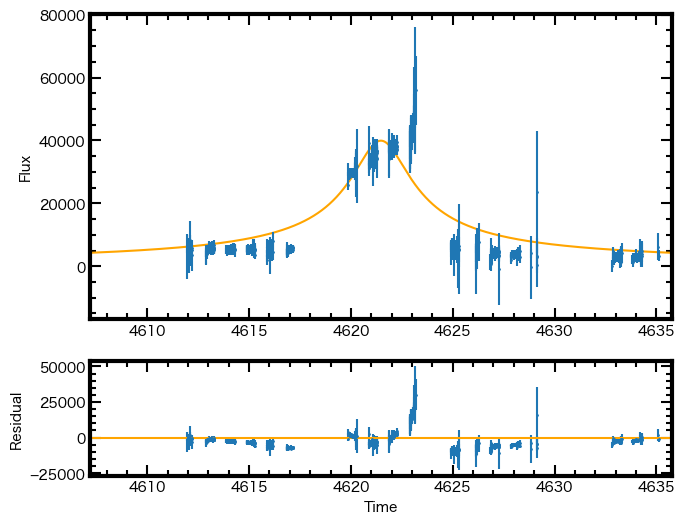

In [11]:
tmp.plot_residual_from_PSPL(markersize=1)
plt.show()

In [5]:
tmp.run_grid_search(teff_init=0.3,teff_grid=13,common_ratio=4/3)

Total time for the search: 10.789031982421875 seconds


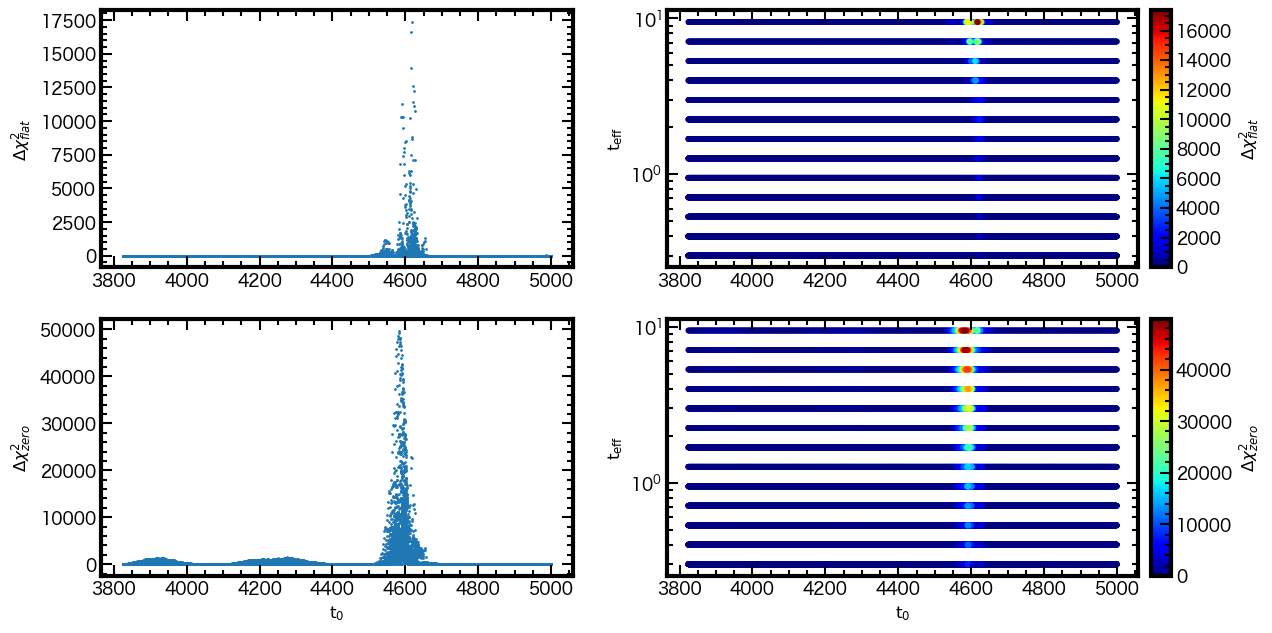

In [6]:
tmp.show_grid_search_result(s=1)

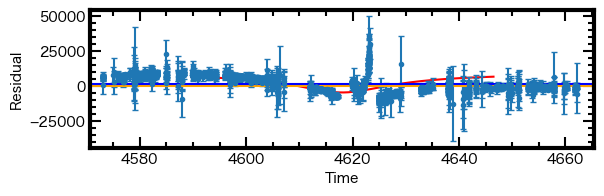

In [7]:
tmp.show_anomaly_signal(which="flat",markersize=3,capsize=2)